We study the following setup

$$
\begin{align}
Y &\sim \mathrm{Unif}(\{\pm1\}) \\
X | Y &\sim \mathcal{N}(Y \cdot c \cdot \mathbf{e_1}, I_d).
\end{align}
$$

We let our adversary perturb inputs up to $\epsilon$ in L2-norm.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from tqdm.notebook import tqdm

In [2]:
def Q(x):
    return 1 - scipy.stats.norm.cdf(x)

def natErr(c, cos_theta, b=0):
    return 0.5 * Q(c * cos_theta + b) + 0.5 * Q(c * cos_theta - b)

def advErr(c, eps, cos_theta, b=0):
    return 0.5 * Q(c * cos_theta - eps + b) + 0.5 * Q(c * cos_theta - eps - b)

def natAdvErrs(c, eps, cos_theta, b=0):
    return np.stack((
        natErr(c=c, cos_theta=cos_theta, b=b),
        advErr(c=c, eps=eps, cos_theta=cos_theta, b=b)
    ), axis=-1)

natAdvErrs(2, 0, np.cos(0)), natAdvErrs(2, 10, np.cos(0))

(array([0.02275013, 0.02275013]), array([0.02275013, 1.        ]))

# No bias

In [3]:
def plot_pts_no_bias(cs, epss, cts, **plt_kwargs):
    for eps in epss:
        for c in cs:
            pts = natAdvErrs(c, eps, cts)
            plt.plot(pts[:, 0], pts[:, 1], label=f"c={c}; $\epsilon$={eps}; $\\tilde b$=0", **plt_kwargs)

### Varying c

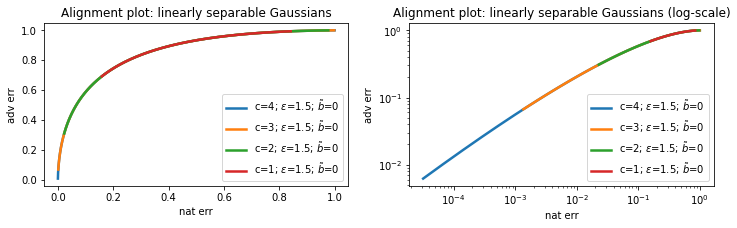

In [4]:
CTS = np.linspace(start=1, stop=-1, num=1000)
CS = [4, 3, 2, 1]
EPSS = [1.5]

def plt_main():
    plot_pts_no_bias(cs=CS, epss=EPSS, cts=CTS, lw=2.5);
    plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1);
    plt.xlabel("nat err");
    plt.ylabel("adv err");

plt.figure(figsize=(12, 3));

plt.subplot(1, 2, 1);
plt_main();
plt.title("Alignment plot: linearly separable Gaussians");

plt.subplot(1, 2, 2);
plt_main();
plt.xscale("log"); plt.yscale("log");
plt.title("Alignment plot: linearly separable Gaussians (log-scale)");

### Varying eps

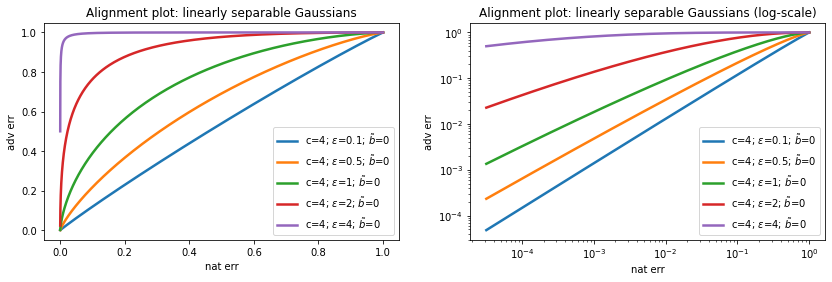

In [5]:
CTS = np.linspace(start=1, stop=-1, num=1000)
CS = [4]
EPSS = [0.1, 0.5, 1, 2, 4]

def plt_main():
    plot_pts_no_bias(cs=CS, epss=EPSS, cts=CTS, lw=2.5);
    plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1);
    plt.xlabel("nat err");
    plt.ylabel("adv err");

plt.figure(figsize=(14, 4));

plt.subplot(1, 2, 1);
plt_main();
plt.title("Alignment plot: linearly separable Gaussians");

plt.subplot(1, 2, 2);
plt_main();
plt.xscale("log"); plt.yscale("log");
plt.title("Alignment plot: linearly separable Gaussians (log-scale)");

Even though natura and error are monotonically aligned,
for large epsilon perturbations,
adversarial error is much harder to minimize than natural error.

Note that dimension does not impact alignment in the infinite sample regime.
That is to say, the set of possible performances is independent of dimension.

# With bias

In [6]:
def plot_pts_with_bias(cs, epss, cts, bs, **plt_kwargs):
    for eps in epss:
        for c in cs:
            for ct in cts:
                pts = natAdvErrs(c, eps, ct, b=bs)
                plt.plot(pts[:, 0], pts[:, 1], label=f"c={c}; $\epsilon$={eps}; $\\tilde v_1$={ct}", **plt_kwargs)

def plot_bias_region(cs, epss, num_ct, max_b, num_b, **plt_kwargs):
    cos_thetas = np.linspace(start=1, stop=-1, num=num_ct)
    bs = np.linspace(start=0, stop=max_b, num=num_b)
    
    for eps in epss:
        for c in cs:
            lo_pts = np.append(
                natAdvErrs(c, eps, cos_theta=1, b=bs),
                natAdvErrs(c, eps, cos_theta=-1, b=np.flip(bs)),
                axis=0,
            )
            hi_pts = natAdvErrs(c, eps, cos_theta=cos_thetas, b=0)
            
            # from https://stackoverflow.com/a/54256731/1337463
            plt.fill(
                np.append(lo_pts[:,0], hi_pts[::-1,0]),
                np.append(lo_pts[:,1], hi_pts[::-1,1]),
                label=f"c={c}; $\epsilon$={eps}",
                **plt_kwargs
            )

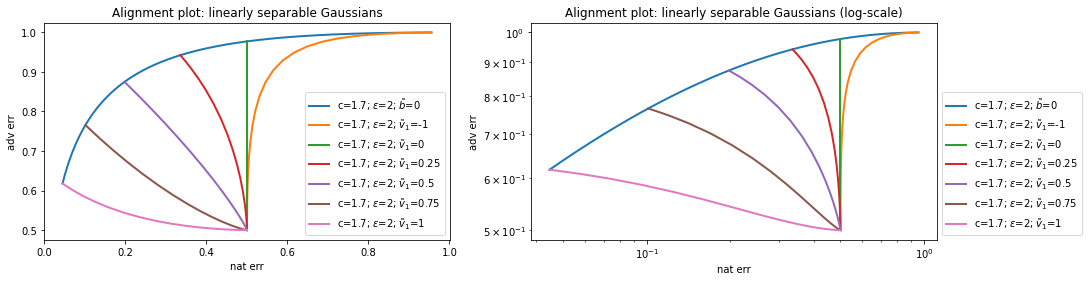

In [7]:
CS = [1.7]
EPSS = [2]
CTS = [-1, 0, 0.25, 0.5, 0.75, 1]
BS = np.linspace(start=0, stop=20, num=100)

def plt_main():
    plot_pts_no_bias(cs=CS, epss=EPSS, cts=np.linspace(start=1, stop=-1, num=1000), lw=2);
    plot_pts_with_bias(cs=CS, epss=EPSS, cts=CTS, bs=BS, lw=2);
    plt.xlabel("nat err");
    plt.ylabel("adv err");

plt.figure(figsize=(16, 4));

plt.subplot(1, 2, 1);
plt_main();
plt.title("Alignment plot: linearly separable Gaussians");
plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1);

plt.subplot(1, 2, 2);
plt_main();
plt.xscale("log"); plt.yscale("log");
plt.title("Alignment plot: linearly separable Gaussians (log-scale)");
plt.legend(bbox_to_anchor=(1, 0), loc='lower left', ncol=1);

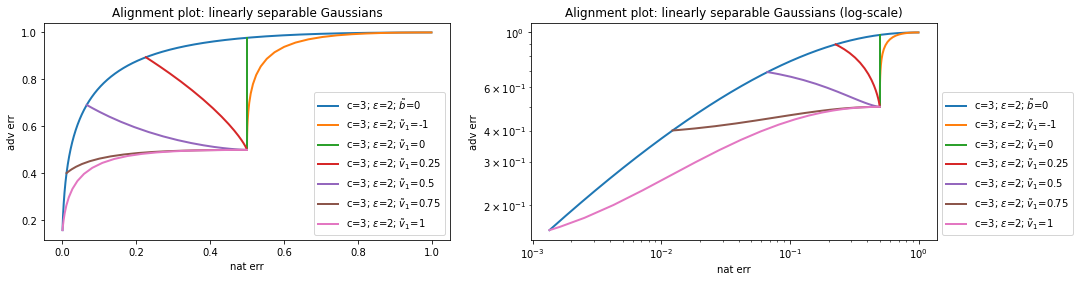

In [8]:
CS = [3]
EPSS = [2]
CTS = [-1, 0, 0.25, 0.5, 0.75, 1]
BS = np.linspace(start=0, stop=20, num=100)

def plt_main():
    plot_pts_no_bias(cs=CS, epss=EPSS, cts=np.linspace(start=1, stop=-1, num=1000), lw=2);
    plot_pts_with_bias(cs=CS, epss=EPSS, cts=CTS, bs=BS, lw=2);
    plt.xlabel("nat err");
    plt.ylabel("adv err");

plt.figure(figsize=(16, 4));

plt.subplot(1, 2, 1);
plt_main();
plt.title("Alignment plot: linearly separable Gaussians");
plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1);

plt.subplot(1, 2, 2);
plt_main();
plt.xscale("log"); plt.yscale("log");
plt.title("Alignment plot: linearly separable Gaussians (log-scale)");
plt.legend(bbox_to_anchor=(1, 0), loc='lower left', ncol=1);

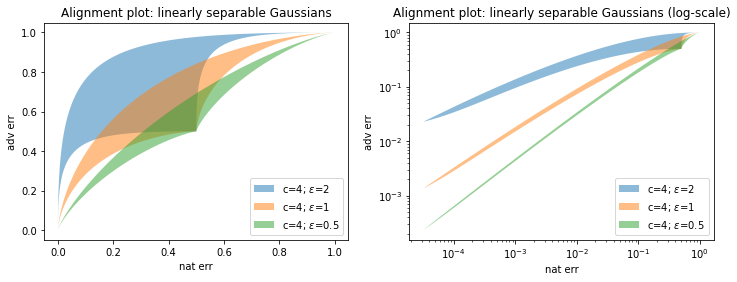

In [9]:
CS = [4]
EPSS = [2, 1, 0.5]

def plt_main():
    plot_bias_region(cs=CS, epss=EPSS, num_ct=1000, max_b=20, num_b=1000, alpha=0.5);
    plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1);
    plt.xlabel("nat err");
    plt.ylabel("adv err");

plt.figure(figsize=(12, 4));

plt.subplot(1, 2, 1);
plt_main();
plt.title("Alignment plot: linearly separable Gaussians");

plt.subplot(1, 2, 2);
plt_main();
plt.xscale("log"); plt.yscale("log");
plt.title("Alignment plot: linearly separable Gaussians (log-scale)");

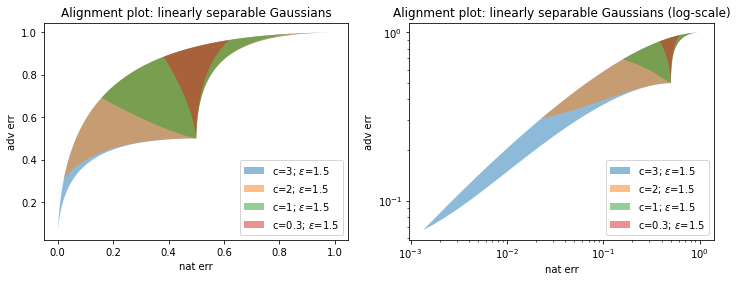

In [10]:
CS = [3,2,1,0.3]
EPSS = [1.5]

def plt_main():
    plot_bias_region(cs=CS, epss=EPSS, num_ct=1000, max_b=20, num_b=1000, alpha=0.5);
    plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1);
    plt.xlabel("nat err");
    plt.ylabel("adv err");

plt.figure(figsize=(12, 4));

plt.subplot(1, 2, 1);
plt_main();
plt.title("Alignment plot: linearly separable Gaussians");

plt.subplot(1, 2, 2);
plt_main();
plt.xscale("log"); plt.yscale("log");
plt.title("Alignment plot: linearly separable Gaussians (log-scale)");

The lower boundary is obtained by fixing $\theta = 0$ or $\theta = \pi$ and varying the bias $b$ from 0 to $\infty$.

The upper boundary is obtained by fixing the bias $b = 0$ and varying $\theta$.

# Finite-sample effects

### Simulation code

In [11]:
def naive_simulation(c, eps, d, ns, num_samples):
    nat_errs = []
    adv_errs = []
    for n in tqdm(ns):
        xs = np.random.normal(size=(num_samples, n, d))
        xs[:, :, 0] += c

        v_hat = xs.mean(axis=1)
        v_hat_norm = v_hat / np.linalg.norm(v_hat, axis=1, keepdims=True)

        cos_thetas = v_hat_norm[:, 0]
        nat_errs.append(natErr(c=c, cos_theta=cos_thetas))
        adv_errs.append(advErr(c=c, eps=eps, cos_theta=cos_thetas))

    nat_errs = np.array(nat_errs)
    adv_errs = np.array(adv_errs)
    
    return nat_errs, adv_errs

def fast_simulation(c, eps, d, ns, num_samples):
    nat_errs = []
    adv_errs = []
    for n in tqdm(ns):
        v1s = np.random.normal(loc=c, scale=1 / np.sqrt(n), size=num_samples)
        add_norms = np.random.chisquare(df=d-1, size=num_samples)

        norms = np.sqrt(v1s ** 2 + add_norms / n)

        cos_thetas = v1s / norms
        nat_errs.append(natErr(c=c, cos_theta=cos_thetas))
        adv_errs.append(advErr(c=c, eps=eps, cos_theta=cos_thetas))

    nat_errs = np.array(nat_errs)
    adv_errs = np.array(adv_errs)
    
    return nat_errs, adv_errs

### Plotting code

In [12]:
def plot_with_cis(
    xs: np.ndarray,
    ys: np.ndarray,
    num_stds : float = 2,
    **plt_kwargs,
):
    """Code from https://stackoverflow.com/a/59747610/1337463"""
    means = ys.mean(axis=-1)
    stds = ys.std(axis=-1)
    
    cis_lo = means - num_stds * stds
    cis_hi = means + num_stds * stds
    
    plt.plot(xs, means, **plt_kwargs)
    if num_stds > 0:
        plt.fill_between(xs, cis_lo, cis_hi, alpha=.4)

### Check naive and fast simulations match

In [13]:
%%time
np.random.seed(42)

C = 4
EPS = 2
D = 50 ** 2
NS = 1 + np.arange(200)
NUM_SAMPLES = 10

naive_res = naive_simulation(
    c=C, eps=EPS, d=D, ns=NS, num_samples=NUM_SAMPLES
)

fast_res = fast_simulation(
    c=C, eps=EPS, d=D, ns=NS, num_samples=NUM_SAMPLES
)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 11.1 s, sys: 887 ms, total: 11.9 s
Wall time: 11.9 s


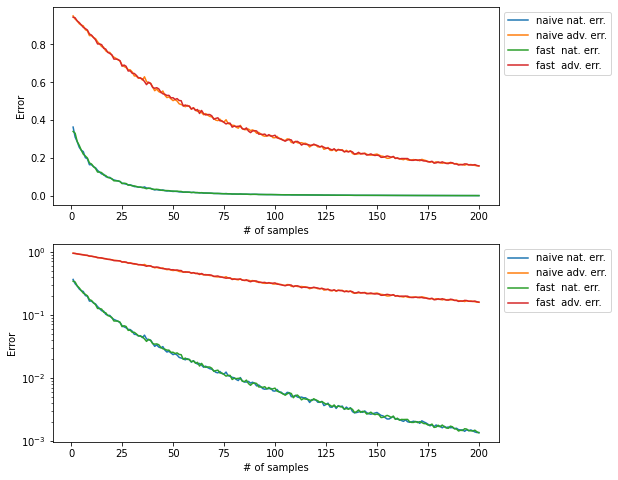

In [14]:
plt.figure(figsize=(8, 8));

def main_plot():
    plot_with_cis(NS, naive_res[0], num_stds=0, label="naive nat. err.")
    plot_with_cis(NS, naive_res[1], num_stds=0, label="naive adv. err.")
    plot_with_cis(NS, fast_res[0], num_stds=0,  label="fast  nat. err.")
    plot_with_cis(NS, fast_res[1], num_stds=0,  label="fast  adv. err.")

    plt.xlabel("# of samples");
    plt.ylabel("Error");

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

plt.subplot(2, 1, 1)
main_plot()

plt.subplot(2, 1, 2)
main_plot()
plt.yscale("log");

### Large scale plots w/ fast simulation

In [15]:
%%time
np.random.seed(42)

C = 4
EPS = 1.5

D = 50 ** 2
NS = np.concatenate([
    np.arange(1, 1000),
    np.arange(1000, 10 ** 5, 100),
    #np.arange(10 ** 5, 10 ** 7, 10 ** 4),
])
NUM_SAMPLES = 100

nat_errs, adv_errs = fast_simulation(
    c=C, eps=EPS, d=D, ns=NS, num_samples=NUM_SAMPLES
)

  0%|          | 0/1989 [00:00<?, ?it/s]

CPU times: user 688 ms, sys: 9.76 ms, total: 698 ms
Wall time: 693 ms


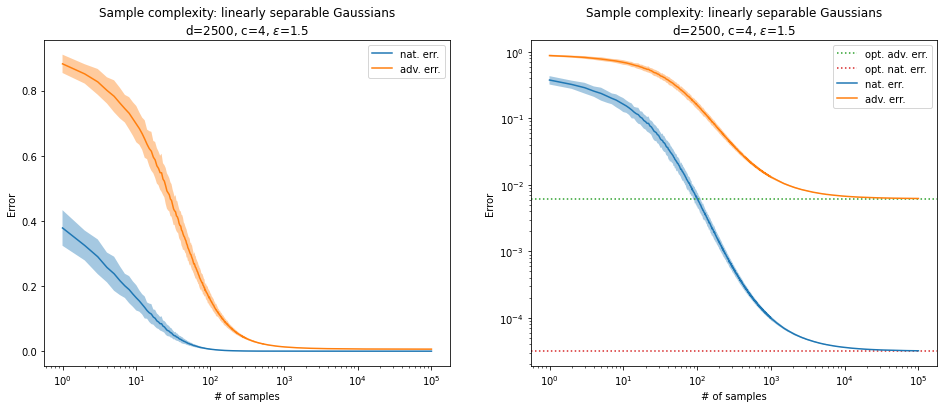

In [16]:
def main_plot():
    plot_with_cis(NS, nat_errs, label="nat. err.")
    plot_with_cis(NS, adv_errs, label="adv. err.")

    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1);

    plt.xlabel("# of samples");
    plt.ylabel("Error");

    plt.title(f"Sample complexity: linearly separable Gaussians\nd={D}, c={C}, $\epsilon$={EPS}");

plt.figure(figsize=(16, 6));
    
plt.subplot(1, 2, 1)
main_plot()
plt.xscale("log");

plt.subplot(1, 2, 2)
plt.xscale("log"); plt.yscale("log");
plt.axhline(
    y=advErr(c=C, eps=EPS, cos_theta=1),
    c="tab:green", linestyle="dotted",
    label="opt. adv. err."
)
plt.axhline(
    y=natErr(c=C, cos_theta=1),
    c="tab:red", linestyle="dotted",
    label="opt. nat. err."
)
main_plot()